# Drafting occupancy standard inputs generation strategy from CBECS

## What do we know

- OPEN24
- OPENMF
- OPENWE
- WKHRS

## Procedures

1. With known information items, we first make a simple heuristic decision of how many hours the building is occupied on a day (weekday or weekend)
    - for example: if
        - OPEN24 = No
        - OPENMF = Yes
        - OPENWE = No
        - WKHRS = 40
        then
        - we assume the building opens $N = 8$ working hours a day on weekdays, and 0 hours on weekends.
        - We assume, on a weekday, the building is open from 9:00 $(13 - N/2)$ to 17:00 $(13 + N/2)$.
2. We make engineering judgment about the occupancy profile shape by specifying occupancy level at certain points
    - 12AM: 0 
    - 8AM ($(13 - N/2) - 1$): 0
    - 10AM ($(13 - N/2) - 1$): 1
    - 12PM (lunch break): 0.8
    - 4PM ($(13 + N/2) - 1$): 1
    - 6PM ($(13 + N/2) + 1$): 0
3. Interpolate the above point into a 24 hour occupancy vector
4. Use the generated occupancy vector as the mean function to formulate a Gaussian Process

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
# plt.style.use(['seaborn-whitegrid'])

Step 1:

In [2]:
N = 10

Step 2&3:

Step 4: Use an RBF kernal Gaussian Process at hour values
    - the interpolated data as the means of the multi-variate Gaussian
    - RBF kernal covariance matrix representing the smoothness and noise of the hourly time series

In [5]:
def plot_gp(n=8, num_sample = 1, limit_step=True, squeeze=True):
    
    LENSCALE = 1
    KERNALSHRINK = 10
    NOISESHRINK = 100
    NUMSAMPLES = num_sample
    STEP = 0.05
    ZOOM = 1.1
    
    #step 2
    x = np.linspace(0, 23, num = 24, endpoint = True)
    xp = [0, 13 - N / 2 - 1, 13 - N / 2 + 1, 12, 13 + N / 2 - 1, 13 + N / 2 + 1]
    yp = [0, 0, 1, 0.8, 1, 0]
    
    #step 3
    mean_func = np.interp(x, xp, yp)
    plt.figure(figsize = (16, 4))
    sns.scatterplot(x=range(24), y=mean_func)
    plt.title("prior: mean of the multi variate gaussian")
    plt.xlabel('hour of day')
    plt.ylabel('occupancy level')
    plt.show()
    
    #step 4
    K = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            K[i, j] = np.exp(-1/2*((x[i] - x[j])**2 / LENSCALE)) / KERNALSHRINK
    
    samples = []
    for i in range(NUMSAMPLES):
        samples.append(np.random.multivariate_normal(mean_func, K, tol=1e-6))
    # convert to pdDataFrame and plot
    colName = []
    for i in range(NUMSAMPLES):
        colName.append('sample ' + str(i+1))
    samplesdf = pd.DataFrame(data = np.array(samples).T, index = x, columns=colName)

    # limit sampled values to [0,1] with step changes

    step_factor = 1 / STEP
    def zeroone(x):
        if x < 0: return 0
        if x > 1: return 1
        return int(x*step_factor + 0.5 ) / step_factor
    def zoom(x):
        return (x - 0.5) * ZOOM + 0.5 
    if squeeze: samplesdf = samplesdf.applymap(lambda x: zoom(x))
    if limit_step: samplesdf = samplesdf.applymap(lambda x: zeroone(x))
    samplesdf.plot(figsize = (16, 4))
    plt.title('Sampled hourly schedule of a day')
    plt.xlabel('hour of day')
    plt.ylabel('occupancy level')
    plt.show()
    samplesdf['x'] = samplesdf.index
    sns.catplot(x='x', y='vals', hue='cols', data=samplesdf.melt('x', var_name='cols', value_name='vals'), height=3, aspect=4)
    plt.xlabel('hour of day')
    plt.ylabel('occupancy level')
    plt.title('Sampled hourly schedule of a day')
    plt.show()
    del samplesdf['x']
    display(samplesdf)
    return samplesdf

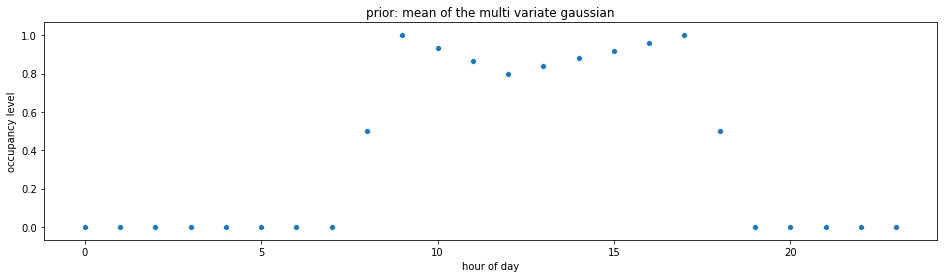

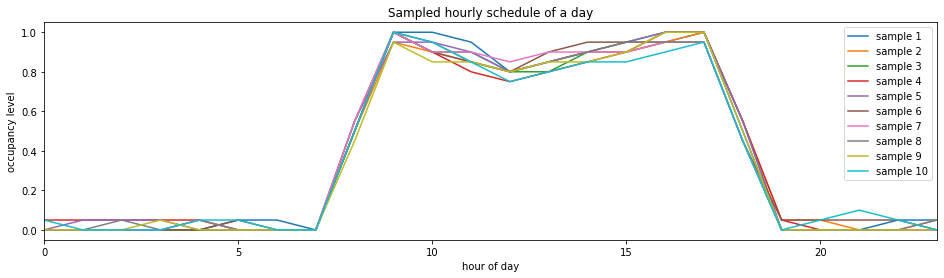

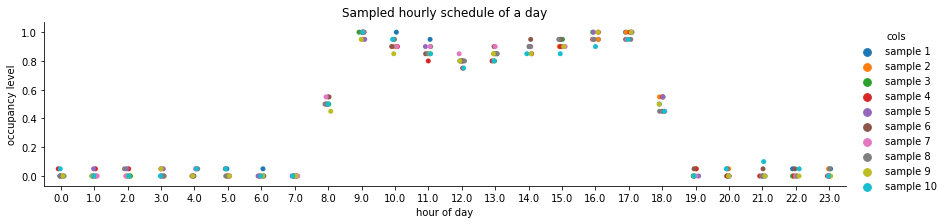

,sample 1,sample 2,sample 3,sample 4,sample 5,sample 6,sample 7,sample 8,sample 9,sample 10
0.0,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.05
1.0,0.00,0.00,0.00,0.05,0.05,0.00,0.00,0.00,0.00,0.00
2.0,0.00,0.00,0.00,0.05,0.05,0.00,0.00,0.05,0.00,0.00
3.0,0.00,0.00,0.00,0.05,0.05,0.00,0.00,0.00,0.05,0.00
4.0,0.00,0.00,0.00,0.05,0.00,0.00,0.05,0.05,0.00,0.05
5.0,0.05,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.05
6.0,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8.0,0.50,0.50,0.50,0.50,0.55,0.55,0.55,0.50,0.45,0.50
9.0,1.00,0.95,1.00,1.00,0.95,1.00,1.00,1.00,0.95,1.00


In [6]:
a=plot_gp(n=8, 
        num_sample=10, 
        limit_step=True, 
        squeeze=False)